Set up the dataset, its features, and classifications

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
# file_path = ""  # This was the original line causing the error
file_path = "diabetes_binary_health_indicators_BRFSS2015.csv"  # Replace with the actual file name

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "alexteboul/diabetes-health-indicators-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)
print("First 5 records:", df.head())

# Assuming 'Diabetes_binary' is the target column and the rest are features
X = df.drop(columns=['Diabetes_binary'])  # Select all columns except 'Diabetes_binary' as features
y = df['Diabetes_binary']  # Select 'Diabetes_binary' column as target

<ipython-input-26-7469db6fbd5e>:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       

In [ ]:
import urllib.request
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

We want to create a hot-encoded version of the dataset for use in simple classification models.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Identify columns with values other than 0 or 1
categorical_cols = [col for col in X.columns
                    if is_numeric_dtype(X[col]) and
                    any(val not in (0, 1) for val in X[col].unique())]

# Create the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', categories='auto')

# Fit the encoder on the selected categorical columns
encoder.fit(X.loc[:, categorical_cols])

# Transform the data
encoded_data = encoder.transform(X.loc[:, categorical_cols])

# Create a DataFrame for the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

# Concatenate the encoded data with the original DataFrame, dropping the original categorical columns
X_encoded = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)

# X_encoded now contains your original data with the specified columns one-hot encoded.
X_encoded.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,Education_5.0,Education_6.0,Income_1.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We are given a clean dataset, with no missing variables or predictors. We want to simulate missing data and perform imputation. This way, we can see how well we may respond to real-world scenarios where data is presented with fuzziness and errors.
# Section 1) Simulated Missing Data and Imputation
**Part 1a) Synthetically Remove Data from dataset**

In [ ]:
# Create a version of dataset, X, that has intentionally missing data
# We will start with 5% of all data missing at random

X_missing = X.copy() # We are going to make this the new df with missing values

missing_frac = 0.05
num_variables = X_missing.size
num_missing = int(missing_frac * num_variables)

np.random.seed(42)
row_index = np.random.randint(0, X_missing.shape[0], num_missing)
col_index = np.random.randint(0, X_missing.shape[1], num_missing)

for r, c in zip(row_index, col_index):
    X_missing.iat[r, c] = np.nan



**Part 1b) Impute missing data**

We will employ a univariate imputation (mean & mode), and Iterative Imputing approach

In [ ]:
# Imputation using mean for continuous, mode for binary

X_univariate_imputed = X_missing.copy()

from sklearn.impute import SimpleImputer

continuous_cols = [col for col in X_univariate_imputed.columns if is_numeric_dtype(X_univariate_imputed[col]) and X_univariate_imputed[col].nunique() > 10]
categorical_cols = [col for col in X_univariate_imputed.columns if col not in continuous_cols]

# print("Continuous cols:", continuous_cols)
# print("Categorical cols:", categorical_cols)


mean_imputer= SimpleImputer(strategy='mean')
mode_imputer= SimpleImputer(strategy='most_frequent') #create our two imputers for different categorical columns

X_univariate_imputed[continuous_cols] = mean_imputer.fit_transform(X_univariate_imputed[continuous_cols])
X_univariate_imputed[categorical_cols]=mode_imputer.fit_transform(X_univariate_imputed[categorical_cols])


X_univariate_imputed.head()


# mean_impute = SimpleImputer(strategy='mean')
# X_mean_imputed = mean_impute.fit_transform(X_missing) # Here we get our imputer set up and apply to X_missing
# X_mean_imputed = pd.DataFrame(X_mean_imputed, columns=X_missing.columns, index=X_missing.index)



,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [ ]:
# This block is a quick check to see an example of how this mean/mode imputing technique worked
sample_row = row_index[0]
sample_col = col_index[0]
col_name = X_missing.columns[sample_col]

print("Original:", X.iloc[sample_row, sample_col])
print("Missing version:", X_missing.iloc[sample_row, sample_col])
print("Imputed value:", X_univariate_imputed.iloc[sample_row, sample_col])


Original: 0.0
Missing version: nan
Imputed value: 0.0


Note to project group: I attempted to use K-Nearest Neighbors and it took forever to load. I gave up and tried this new Imputation technique which runs in a matter of seconds

Now we impute using Iterative Imputing technique:

In [ ]:
# Imputation using Iterative Imputing

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

X_iter_imputed =X_missing.copy()

iter_imputer = IterativeImputer(random_state=42, max_iter=10) # set up our iterative imputer

X_iter_array = iter_imputer.fit_transform(X_iter_imputed)   # apply to our data
X_iter_imputed=pd.DataFrame(X_iter_array,columns=X_missing.columns, index=X_missing.index)
X_iter_imputed = X_iter_imputed.round().astype(int)   #We dont want any non-integers (zeros and ones or round numbers)



X_iter_imputed.head()


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [ ]:
# This block is a quick check to see an example of how this mean/mode imputing technique worked
sample_row = row_index[1]
sample_col = col_index[1]
col_name = X_missing.columns[sample_col]

print("Original:", X.iloc[sample_row, sample_col])
print("Missing version:", X_missing.iloc[sample_row, sample_col])
print("Imputed value:", X_iter_imputed.iloc[sample_row, sample_col])

Original: 0.0
Missing version: nan
Imputed value: 0


In [ ]:

column_metrics = []



for col in X.columns:
    # Mask the locations we need
    mask =X_missing[col].isna()

    if mask.sum() == 0:
        continue  #skip columns without missing val

    true_vals = X.loc[mask, col]
    imputed_vals = X_iter_imputed.loc[mask,col]

    # Drop any remaining NaNs (just in case)
    mask_clean=~true_vals.isna()
    true_vals =true_vals[mask_clean]
    imputed_vals= imputed_vals[mask_clean]

    # Compute metrics
    exact_match = np.mean(true_vals ==imputed_vals)
    mae = np.mean(np.abs(true_vals-imputed_vals))

    column_metrics.append({
        'Feature': col,
        'Missing Count': mask.sum(),
        'Exact Match Accuracy': round(exact_match,3),
        'Mean Absolute Error':round(mae, 3)
    })



# Make df with the results
imputation_results =pd.DataFrame(column_metrics).sort_values(by='Exact Match Accuracy',ascending=False)
imputation_results.reset_index(drop=True, inplace=True)

imputation_results


,Feature,Missing Count,Exact Match Accuracy,Mean Absolute Error
0,CholCheck,12444,0.962,0.038
1,Stroke,12310,0.960,0.040
2,AnyHealthcare,12205,0.952,0.048
3,HvyAlcoholConsump,12233,0.945,0.055
4,NoDocbcCost,12459,0.914,0.086
5,HeartDiseaseorAttack,12352,0.904,0.096
6,DiffWalk,12439,0.872,0.128
7,Veggies,12315,0.810,0.190
8,PhysActivity,12395,0.776,0.224
9,HighBP,12220,0.715,0.285


,Feature,Missing Count,Exact Match Accuracy 1,Exact Match Accuracy 2
0,CholCheck,12444,0.961749,0.961749
1,Stroke,12310,0.960439,0.960439
2,AnyHealthcare,12205,0.951987,0.951987
3,HvyAlcoholConsump,12233,0.945148,0.945148
4,NoDocbcCost,12459,0.912272,0.914038
5,HeartDiseaseorAttack,12352,0.903255,0.904226
6,DiffWalk,12439,0.833749,0.872417
7,Veggies,12315,0.809419,0.810150
8,PhysActivity,12395,0.760145,0.775877
9,Fruits,12327,0.635678,0.685487


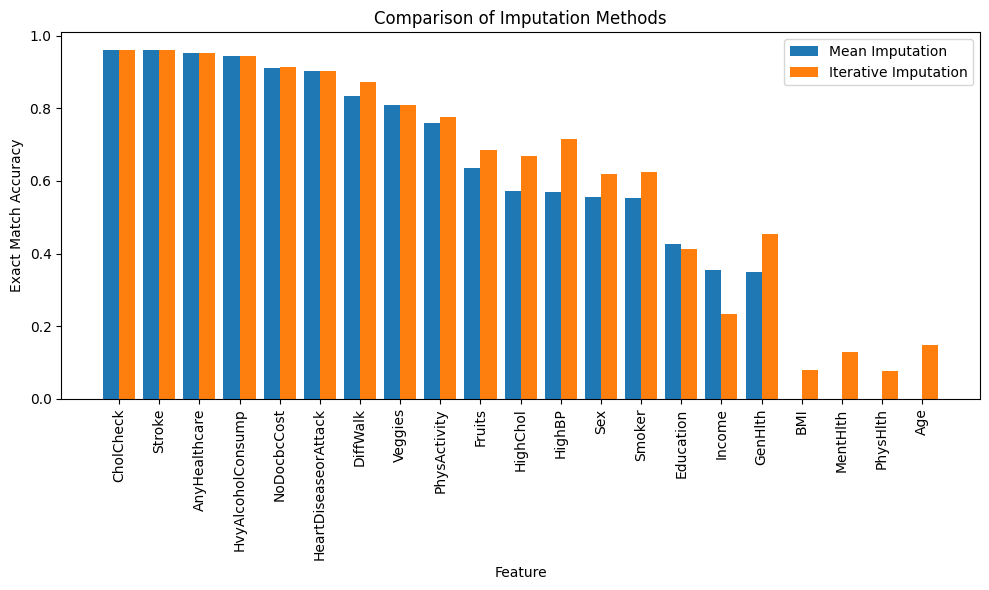

In [ ]:
# Plot and compare the resulting dfs with different imputation styles.
#Lets see where they work and what predictors we can reliably imputate

def compare_data_imputations(X_original, X_missing, X_imputated1, X_imputated2):
  features=X_original.columns
  results=[]

  for col in features:
    mask = X_missing[col].isna()
    if mask.sum() == 0:
      continue


    true_vals= X_original.loc[mask,col]
    imputed1_vals=X_imputated1.loc[mask,col]
    imputed2_vals=X_imputated2.loc[mask,col]

    mask_clean = ~true_vals.isna()
    true_vals = true_vals[mask_clean]
    imputed1_vals = imputed1_vals[mask_clean]
    imputed2_vals = imputed2_vals[mask_clean]



    results.append({'Feature':col,
                    'Missing Count':mask.sum(),
                    'Exact Match Accuracy 1':np.mean(true_vals==imputed1_vals),
                    'Exact Match Accuracy 2':np.mean(true_vals==imputed2_vals)})


  df=pd.DataFrame(results).sort_values(by='Exact Match Accuracy 1',ascending=False)
  df.reset_index(drop=True, inplace=True)


  #plot commands now

  plt.figure(figsize=(10,6))
  x=np.arange(len(df))
  bar_width=0.4


  plt.bar(x,df['Exact Match Accuracy 1'],bar_width,label='Mean Imputation')
  plt.bar(x+bar_width,df['Exact Match Accuracy 2'],bar_width,label='Iterative Imputation')
  plt.xlabel('Feature')
  plt.ylabel('Exact Match Accuracy')
  plt.title('Comparison of Imputation Methods')
  plt.xticks(x+bar_width/2,df['Feature'], rotation=90)
  plt.legend()
  plt.tight_layout()


  return df

compare_data_imputations(X,X_missing,X_univariate_imputed,X_iter_imputed)

# Part 2) Dataset Balancing

Here we check the balance of the dataset:

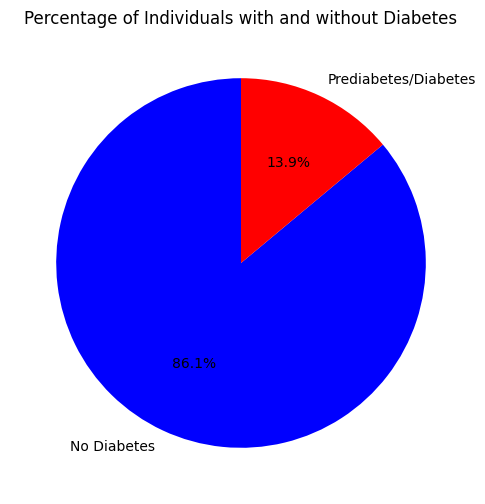

In [ ]:
# Pie chart of the distribution of binary values in dataset y

import matplotlib.pyplot as plt
import pandas as pd

# Calculate counts
diabetes_counts = y.value_counts()

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_counts, labels=['No Diabetes', 'Prediabetes/Diabetes'], autopct='%1.1f%%', startangle=90, colors=['blue','red'])
plt.title('Percentage of Individuals with and without Diabetes')
plt.show()

Our dataset is severely imbalanced. We will address this in the following code, two ways. First, we will employ synthetic minority oversampling technique (SMOTE), to create a balance.

In [ ]:
# Splitting our data
from sklearn.model_selection import train_test_split

# Split off testing data for original (X)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
# Now separate the training into validation and training:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


Balanced shape: (261796, 192) (261796,)


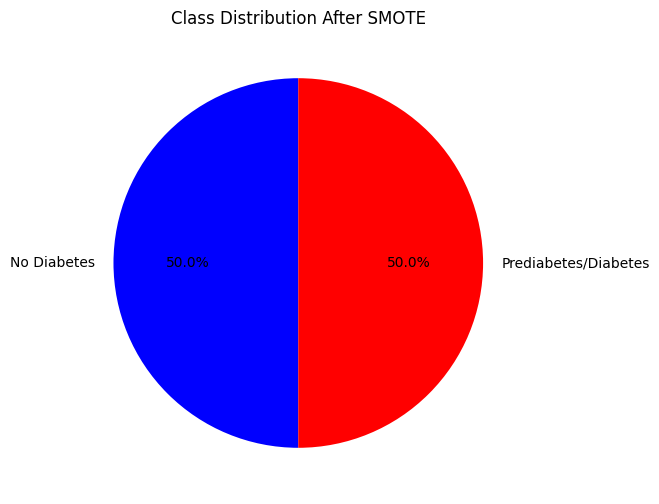

In [ ]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train.values.ravel())

print("Balanced shape:", X_train.shape, y_train.shape)

# Calculate counts
# diabetes_counts = y_balanced.counts()  # Original line causing the error
diabetes_counts = pd.Series(y_train).value_counts() # Convert y_balanced to a pandas Series before calling value_counts()


# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_counts, labels=['No Diabetes', 'Prediabetes/Diabetes'], autopct='%1.1f%%', startangle=90, colors=['blue','red'])
plt.title('Class Distribution After SMOTE')
plt.show()

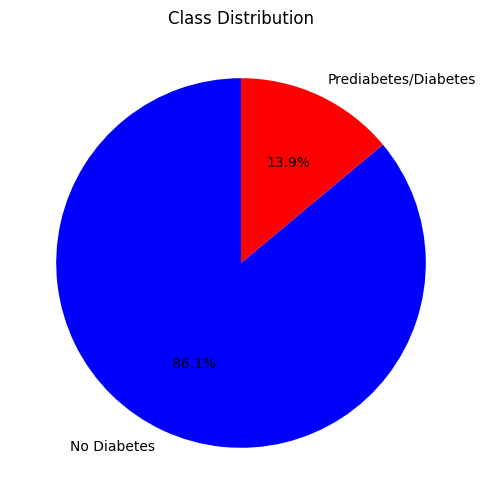

In [ ]:
# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_counts, labels=['No Diabetes', 'Prediabetes/Diabetes'], autopct='%1.1f%%', startangle=90, colors=['blue','red'])
plt.title('Class Distribution')
plt.show()

**XGBoost**

In [ ]:
# XGBoost
from xgboost import XGBClassifier

# Initialize the classifier with logistic regression objective
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',      # evaluation metric for binary classification
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#Accuracy
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, preds)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, preds)
print(f"Recall: {recall:.4f}")

# F1
f1 = f1_score(y_test, preds)
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8612
Precision: 0.8470
Recall: 0.8809
F1-Score: 0.8636


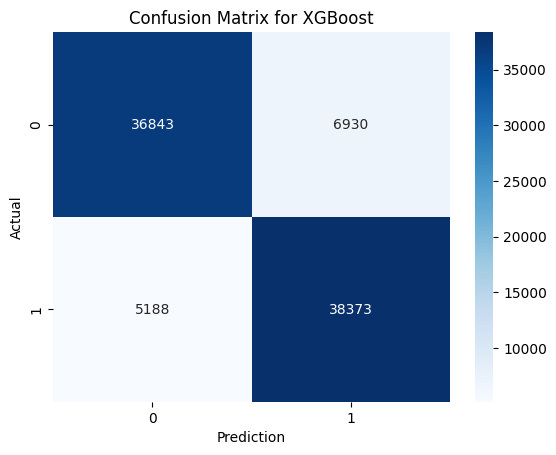

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Here we display a confusion matrix from our XGBoost model
conf_matrixXG = confusion_matrix(y_test, preds)
sns.heatmap(conf_matrixXG, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost")
plt.show()

**Logistic Regression**

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

# Create and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# (Optional) Make predictions
y_pred = model.predict(X_test)

**Logistic Regression Model Metrics**

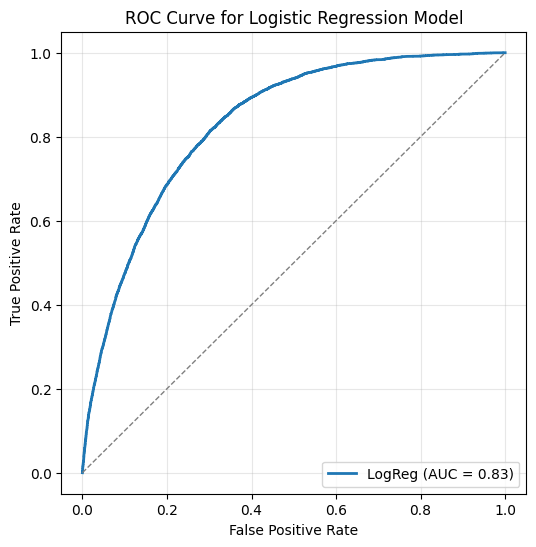

Accuracy: 0.8677
Precision: 0.5627
Recall: 0.1815
F1-Score: 0.2745
ROC AUC: 0.8319


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Assuming y_test are the true labels and y_pred are the predicted labels
# 4. Predict probabilities for the positive class (label “1”)
y_prob = model.predict_proba(X_test)[:, 1]

# 5. Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 6. Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'LogReg (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

#Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

# ROC AUC Score
y_probs = model.predict_proba(X_test)[:, 1]  # probability of 1 (have diabetes)
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC: {roc_auc:.4f}")

**Give User a questionaire and return probability of Diabetes with confidence score**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Here we display a confusion matrix from our logistic regression model
conf_matrix_lr = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()


In [ ]:
# Step 10: Static User Survey (Full Version)
import pandas as pd

# All features (excluding Diabetes_binary), with types and reasonable constraints
feature_definitions = {
    "HighBP": {"type": "int", "options": [0, 1]},
    "HighChol": {"type": "int", "options": [0, 1]},
    "CholCheck": {"type": "int", "options": [0, 1]},
    "BMI": {"type": "float", "range": (10, 50)},
    "Smoker": {"type": "int", "options": [0, 1]},
    "Stroke": {"type": "int", "options": [0, 1]},
    "HeartDiseaseorAttack": {"type": "int", "options": [0, 1]},
    "PhysActivity": {"type": "int", "options": [0, 1]},
    "Fruits": {"type": "int", "options": [0, 1]},
    "Veggies": {"type": "int", "options": [0, 1]},
    "HvyAlcoholConsump": {"type": "int", "options": [0, 1]},
    "AnyHealthcare": {"type": "int", "options": [0, 1]},
    "NoDocbcCost": {"type": "int", "options": [0, 1]},
    "GenHlth": {"type": "int", "range": (1, 5)},
    "MentHlth": {"type": "int", "range": (0, 30)},
    "PhysHlth": {"type": "int", "range": (0, 30)},
    "DiffWalk": {"type": "int", "options": [0, 1]},
    "Sex": {"type": "int", "options": [0, 1]},
    "Age": {"type": "int", "range": (1, 13)},
    "Education": {"type": "int", "range": (1, 6)},
    "Income": {"type": "int", "range": (1, 8)},
}

# Input prompt logic
def prompt_user_for_input(feature_definitions):
    user_data = {}
    for feature, props in feature_definitions.items():
        while True:
            try:
                if "options" in props:
                    options_str = "/".join(map(str, props["options"]))
                    user_input = input(f"{feature} ({options_str}): ")
                    val = int(user_input)
                    if val in props["options"]:
                        user_data[feature] = val
                        break
                    else:
                        print(f"Invalid option. Choose from: {props['options']}")
                elif "range" in props:
                    low, high = props["range"]
                    user_input = input(f"{feature} (range {low}–{high}): ")
                    val = int(user_input) if props["type"] == "int" else float(user_input)
                    if low <= val <= high:
                        user_data[feature] = val
                        break
                    else:
                        print(f"Out of range. Please enter between {low} and {high}")
            except ValueError:
                print("Invalid input. Please enter a valid number.")
    return user_data

# Run the survey
user_inputs = prompt_user_for_input(feature_definitions)
user_df = pd.DataFrame([user_inputs])
print("\nCollected User Input:")
print(user_df)

# Step 11: Predict using trained model with optimized feature alignment
missing_cols = [col for col in X_train.columns if col not in user_df.columns]
missing_df = pd.DataFrame([{col: 0 for col in missing_cols}])
user_df_aligned = pd.concat([user_df.reset_index(drop=True), missing_df], axis=1)
user_df_aligned = user_df_aligned[X_train.columns]

user_risk_class = model.predict(user_df_aligned)[0]
user_risk_proba = model.predict_proba(user_df_aligned)[0][1]

print(f"\n Predicted Diabetes Risk Class: {user_risk_class}")
print(f" Probability of Having Diabetes: {user_risk_proba:.2%}")


HighBP (0/1): 1
HighChol (0/1): 1
CholCheck (0/1): 1
BMI (range 10–50): 30
Smoker (0/1): 1
Stroke (0/1): 0
HeartDiseaseorAttack (0/1): 1
PhysActivity (0/1): 0
Fruits (0/1): 1
Veggies (0/1): 1
HvyAlcoholConsump (0/1): 0
AnyHealthcare (0/1): 1
NoDocbcCost (0/1): 0
GenHlth (range 1–5): 5
MentHlth (range 0–30): 30
PhysHlth (range 0–30): 30
DiffWalk (0/1): 1
Sex (0/1): 0
Age (range 1–13): 9
Education (range 1–6): 5
Income (range 1–8): 1

Collected User Input:
   HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1  30.0       1       0                     1   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0             0       1        1  ...              1            0        5   

   MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  
0        30        30         1    0    9          5       1  

[1 rows x 21 columns]

📊 Predicted Diabetes Risk Class: 1.0
🔬 Probability of Having Diabetes: 59.75%

In [ ]:
# prompt: can we print the features of a participant from the dataset with diabetes?

# Assuming 'df' is your DataFrame loaded from the CSV file.
participant_index = 8  # Replace with the desired participant index

# Print features for the specified participant
df.iloc[participant_index]


,8
Diabetes_binary,1.0
HighBP,1.0
HighChol,1.0
CholCheck,1.0
BMI,30.0
Smoker,1.0
Stroke,0.0
HeartDiseaseorAttack,1.0
PhysActivity,0.0
Fruits,1.0


**Neural Network Implementatiion**

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8553 - auc: 0.9351 - loss: 0.3242 - val_accuracy: 0.7904 - val_auc: 0.7953 - val_loss: 0.4323
Epoch 2/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8580 - auc: 0.9378 - loss: 0.3173 - val_accuracy: 0.7917 - val_auc: 0.7943 - val_loss: 0.4340
Epoch 3/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8600 - auc: 0.9395 - loss: 0.3132 - val_accuracy: 0.7950 - val_auc: 0.7938 - val_loss: 0.4294
Epoch 4/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8627 - auc: 0.9414 - loss: 0.3085 - val_accuracy: 0.7978 - val_auc: 0.7970 - val_loss: 0.4219
Epoch 5/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8625 - auc: 0.9414 - loss: 0.3082 - val_accuracy: 0.8082 - val_auc: 0.7946 - val_loss: 0.4076
Epoch 6/100
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8662 - auc: 0.9450 - loss: 0.2989 - val_accuracy: 0.8013 - val_auc: 0.7925 - val_loss: 0.4174
Epoch 7/10

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

# Predictions:
y_probs_nn =nn_model.predict(X_test).flatten()
y_pred_nn=(y_probs_nn>0.5).astype(int)



#Metric report
print(classification_report(y_test,y_pred_nn)) #Classification report gives valuable metric readout
print("ROC AUC:",roc_auc_score(y_test, y_probs_nn))

# Confusion Matrix
conf_matrix_nn = confusion_matrix(y_test,y_pred_nn)
sns.heatmap(conf_matrix_nn, annot=True,fmt="d",cmap="Blues")
plt.title("Confusion Matrix for Neural Network")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()


NameError: name 'nn_model' is not defined